In [19]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from datetime import datetime
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

In [20]:
# This turns all the axes white in all the matplotlib plots. Comment this out if you dont want that
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR

In [21]:
df_ecommerce = pd.read_csv('datasets/ecommerce/Fraud_Data.csv')
df_ecommerce.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2/24/15 22:55,4/18/15 2:47,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,6/7/15 20:39,6/8/15 1:38,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,1/1/15 18:52,1/1/15 18:52,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,4/28/15 21:13,5/4/15 13:54,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,7/21/15 7:09,9/9/15 18:40,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [22]:
# Features that are used, isFraud is the target
features = ['purchase_value', 'source', 'browser', 'sex', 'age', 'class']
df = df_ecommerce[features]
df.size

906672

In [23]:
# Sort features into categorical and numerical types
target = 'class'
# Categorical features
cat = ['source', 'browser', 'sex'] 
num = ['purchase_value', 'age']

In [24]:
# Drop rows with missing features
df = df.dropna()
y = df[target].values
df.head()

,purchase_value,source,browser,sex,age,class
0,34,SEO,Chrome,M,39,0
1,16,Ads,Chrome,F,53,0
2,15,SEO,Opera,M,53,1
3,44,SEO,Safari,M,41,0
4,39,Ads,Safari,M,45,0


In [25]:
x_cat = df.filter(items = cat).values
x_num = df.filter(items = num).values

In [26]:
labelencoder_X = LabelEncoder()
# Label encode every categorical column
for i in range(len(cat)): 
    x_cat[:, i] = labelencoder_X.fit_transform(x_cat[:, i])

In [37]:
# Build input vector X, the training data
X = np.concatenate((x_cat, x_num), axis=1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
len(X_train), len(X_test),len(y_train), len(y_test)

(105778, 45334, 105778, 45334)

In [47]:
# resampling using SMOTETomek 
resamp = SMOTETomek(random_state=0)
X_test_resample, y_test_resample = resamp.fit_resample(X_test, y_test)
len(X_test_resample),len(y_test_resample)

(81950, 81950)

In [49]:
# random undersampling
undersample = RandomUnderSampler(random_state=0)

X_train_usample, y_train_usample = undersample.fit_resample(X_train, y_train)
X_test_usample, y_test_usample = undersample.fit_resample(X_test, y_test)

len(X_train_usample), len(X_test_usample), len(y_train_usample), len(y_test_usample)

(19988, 8314, 19988, 8314)

In [50]:
# feature scaling - prepares training and test data for ML by standardizing features to have similar scales
sc = StandardScaler()
sc.fit(X_train_usample)
X_train_std = sc.transform(X_train_usample)
X_test_std = sc.transform(X_test)
#Y_train_std = sc.transform(y_train)
#Y_test_std = sc.transform(y_test)

len(X_train_std), len(X_test_std)

(19988, 45334)

In [51]:
model_linear = SVC(C=1,kernel='linear')
model_linear.fit(X_train_std, y_train_usample)

SVC(C=1, kernel='linear')

In [52]:
pred = model_linear.predict(X_test_std)
print(accuracy_score(y_test,pred))

0.43285392861869676


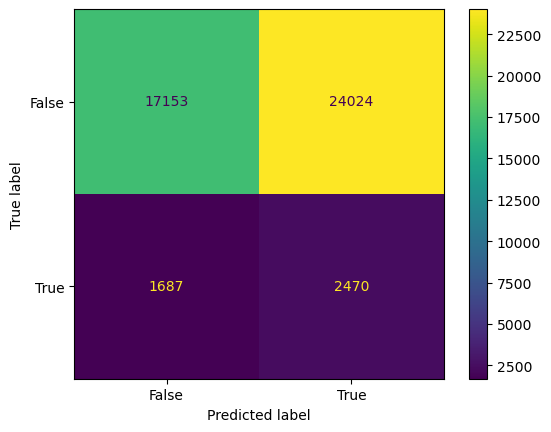

In [54]:
confusion_matrix = metrics.confusion_matrix(y_test, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [44]:
#### Make a function to do all of this
# inputs: lower bound, upper bound, step for C values, kernel type (linear, poly, rbf) 

def tuner(range, kernel):
    ''' 
    range (list of floats): lower, upper, and step for values of c 
    kernel (str): 'linear', 'poly' 'rbf' (could also include sigmoid)
    prints the accuracy of model of specified type with all c values in given range
    '''
    results = {}
    for c in np.arange(range[0],range[1],range[2]):
        c = round(c,3)
        model = SVC(C=c, kernel=kernel)
        model.fit(X_train_std, y_train)
        pred = model.predict(X_test_std)
        results[c] = accuracy_score(y_test,pred)

    return(results)

def plot_tuning(results):
    '''
    results (dict): dictionary of results of hyperparameter tuning
    displays a graph of the regularization paramater value against model accuracy
    '''
    c_vals = list(results.keys())
    accuracy_vals = list(results.values())

    for r in results:
        print("model with regularization parameter " + str(round(r,3)) + " had accuracy " + str(round(results[r],3)))

    increment = list(results.keys())[1] - list(results.keys())[0]
    plt.plot(c_vals, accuracy_vals, 'ro')
    plt.xlim(list(results.keys())[0] - increment, list(results.keys())[-1] + increment)
    plt.ylim(0,1.1)
    plt.xticks(np.arange(list(results.keys())[0] - increment, list(results.keys())[-1] + increment, increment))
    plt.show()

In [46]:
res = tuner([0.01,1,.2], 'linear')

model with regularization parameter 0.01 had accuracy 0.908
model with regularization parameter 0.21 had accuracy 0.908
model with regularization parameter 0.41 had accuracy 0.908
model with regularization parameter 0.61 had accuracy 0.908
model with regularization parameter 0.81 had accuracy 0.908


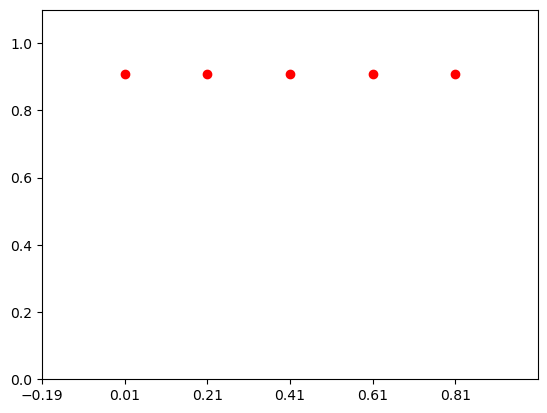

In [47]:
plot_tuning(res)

Notes: recommended to scale your data before using an SVM, can be done using a pipeline, could try different kernel functions, look more into run-time of SVM